# Analysis Goal

We are running a digitial marketing campaign for a client. 
Our main metrics are number of clicks, number of impressions, money spent on impressions (cost).

After 11 days we would like to assess our metrics and decide whether it would pay off to spend additional money. 

## Baseline posteriors analysis

We will use the data observed after 11 days to get the posterior distribution for each metric. This will tell us, if we keep the campaign parameters unchanged, then we can get an idea of what to expect at the end of the campaign. 

## Posterior comparative analysis

We want to simulate 2 scenarios:
- scenario 1: Impressions increase by 10% with additional money spent, we simulate 5% increase in CTR
- scenario 2: Impressions increase by 10%, we simulate 10% increase in CTR

Then we do posterior distribution analysis between the base and the two scenarios.

### Conclusion

We want to recommend whether it is worth while for the client to increase spending on the current running campaign. 





In [132]:
import numpy as npq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
# Ensure plots are displayed inline in the notebook
%matplotlib inline


# Click Through Rate Prior and Posterior

For CTR we start off with a prior using a beta(1,1) distribution

Then after seeing the data 11 days into the campaign, we adjust the prior to get our CTR posterior using a  beta( #success + 1, #trials - # successes - 1) distribution.

Where #success = total clicks over 11 days, and #trials = total number of impressions over 11 days of campaign.

To simulate the CTR increases we will adjust the CTR with 1.05 and 1.1 respectively but keep the observed total Impressions the same. 


In [133]:
beta_a = 1
beta_b = 1
nr_draws = 10000

# CTR prior before seeing the data
ctr_prior_draws = npq.random.beta(beta_a, beta_b, size=nr_draws)

#after running the campaign 11 days
nr_clicks = 224
nr_impressions = 26439 

#CTR posterior base
ctr_posterior_base_draws = npq.random.beta(nr_clicks + beta_a, nr_impressions - nr_clicks + beta_b, size=nr_draws)

# simulate 2 increase scenarios
nr_clicks_1_05 = nr_clicks * 1.05
nr_clicks_1_10 = nr_clicks * 1.10

#scenario 1: CTR posterior for 5% CTR increase and 10% impressions increase
ctr_posterior_1_05_draws = npq.random.beta(nr_clicks_1_05 + beta_a, nr_impressions - nr_clicks_1_05 + beta_b, size=nr_draws)

#scenario 2: CTR posterior for 10% CTR increase and 10% impressions increase
ctr_posterior_1_10_draws = npq.random.beta(nr_clicks_1_10 + beta_a, nr_impressions - nr_clicks_1_10 + beta_b, size=nr_draws)


ctr_posteriors_df = pd.DataFrame({
    "prior" : ctr_prior_draws,
    "base" : ctr_posterior_base_draws,
    "1_05"       : ctr_posterior_1_05_draws,
    "1_10"       : ctr_posterior_1_10_draws,
})

print(ctr_posteriors_df.describe())

              prior          base          1_05          1_10
count  10000.000000  10000.000000  10000.000000  10000.000000
mean       0.504340      0.008515      0.008936      0.009362
std        0.287670      0.000568      0.000581      0.000589
min        0.000008      0.006282      0.006939      0.007263
25%        0.256022      0.008122      0.008543      0.008960
50%        0.506809      0.008496      0.008915      0.009345
75%        0.754044      0.008893      0.009315      0.009754
max        0.999756      0.011050      0.011414      0.011958


<AxesSubplot:ylabel='Density'>

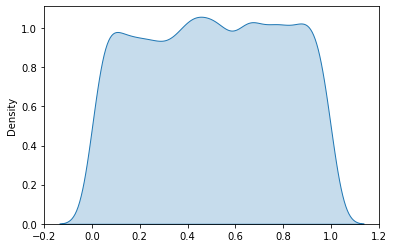

In [134]:
# For honest reporting we show our prior
sns.kdeplot(ctr_prior_draws, shade = True, label="CTR Prior")

# Let's plot our CTR posterior distributions


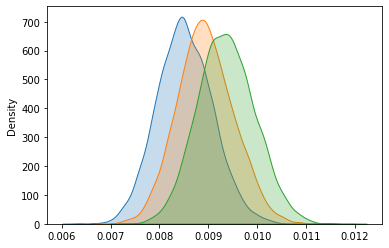

In [135]:
# put all the plots on one graph
sns.kdeplot(ctr_posterior_base_draws, shade = True, label="CTR Base")
sns.kdeplot(ctr_posterior_1_05_draws, shade = True, label="CTR + 5%")
sns.kdeplot(ctr_posterior_1_10_draws, shade = True, label="CTR + 10%")
plt.show()

# Impressions Prior and Posterior

We model the Impressions as a Poisson distribution with expected 2,000 impressions per day (lambda)

After observing the data 11 days into the campaign we use the conjugate prior for a Poisson which is a Gamma distribution and adjust the parameters to get the posterior distribution. 

We will use k as the total occurrences in 1/theta intervals.


              prior          base          1_10
count  10000.000000  10000.000000  10000.000000
mean    1999.590099   2370.006967   2590.293715
std       44.851490     14.112076     14.665662
min     1849.113961   2322.193172   2527.569143
25%     1968.742967   2360.356173   2580.419213
50%     1998.733425   2369.911923   2590.344091
75%     2029.198148   2379.615276   2600.194028
max     2156.863236   2425.480391   2646.304789


<AxesSubplot:ylabel='Density'>

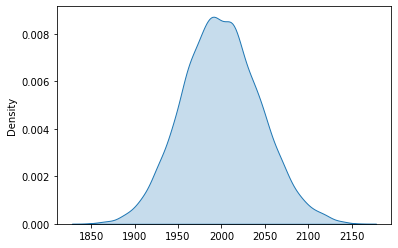

In [136]:
# Our gamma prior we expect 2,000 in 1 interval
k = 2000
theta = 1

impression_prior_draws = npq.random.gamma(shape=k, scale=theta, size = nr_draws)

# now let's do the posterior drawn from Gamma distribution with adjusted parameters after seeing the data
nr_days = 11
total_impressions = 26439 # for 11 days

post_k = k + total_impressions
post_theta = theta/(nr_days*theta+1)

impression_post_base_draws = npq.random.gamma(shape=post_k, scale=post_theta, size = nr_draws)

# now let's do the 10% impression increase
k_1_10 = k + total_impressions * 1.1

impression_post_1_10_draws = npq.random.gamma(shape=k_1_10, scale=post_theta, size = nr_draws)

impression_posteriors_df = pd.DataFrame({
    "prior"     : impression_prior_draws,
    "base"      : impression_post_base_draws,
    "1_10"      : impression_post_1_10_draws,
})

print(impression_posteriors_df.describe())

# For honest reporting we show our prior
sns.kdeplot(impression_prior_draws, shade = True, label="Impressions Prior")


# Let's plot our Impression posterior distributions

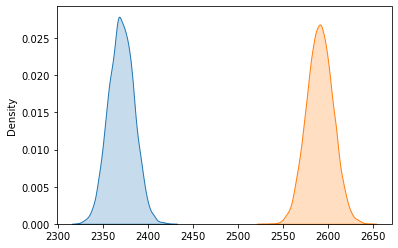

In [137]:
# Now for the Posteriors
# put all the plots on one graph
sns.kdeplot(impression_post_base_draws, shade = True, label="Impressions Base")
sns.kdeplot(impression_post_1_10_draws, shade = True, label="Impressions + 10%")
plt.show()

# Let's do Posterior comparative analysis


In [138]:
# We are after a posterior number of clicks and posterior cost distribution

# Based on observed data we use cost per impression as constant
cost = 0.041612391

post_dict = {
    "ctr_base" : ctr_posterior_base_draws,
    "ctr_1_05" : ctr_posterior_1_05_draws,
    "ctr_1_10" : ctr_posterior_1_10_draws,
    "imp_base" : impression_post_base_draws,
    "imp_1_10" : impression_post_1_10_draws,
    "clicks_base" : ctr_posterior_base_draws * impression_post_base_draws,
    "clicks_1_05" : ctr_posterior_1_05_draws * impression_post_1_10_draws,  #assume 10% Impressions increase
    "clicks_1_10" : ctr_posterior_1_10_draws * impression_post_1_10_draws,  #assume 10% Impressions increase
    "cost_base" :  cost * impression_post_base_draws,
    "cost_1_10" :  cost * impression_post_1_10_draws,
}

# first compare clicks post distributions scenarios
clicks_posteriors_df = pd.DataFrame(
     post_dict
 )

print(clicks_posteriors_df[["clicks_base", "clicks_1_05", "clicks_1_10"]].describe())


        clicks_base   clicks_1_05   clicks_1_10
count  10000.000000  10000.000000  10000.000000
mean      20.180243     23.147743     24.250785
std        1.349026      1.511905      1.532111
min       14.962356     17.856468     18.742113
25%       19.250270     22.125823     23.205680
50%       20.142438     23.087098     24.214982
75%       21.078186     24.123365     25.273247
max       26.314445     29.455371     31.147482


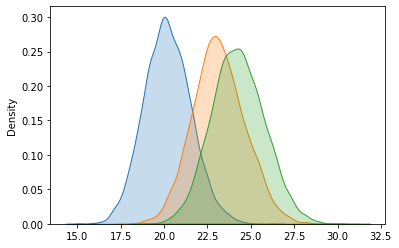

In [139]:
# let's plot the 3 clicks posterior distributions

sns.kdeplot(post_dict["clicks_base"], shade = True, label="Clicks Base")
sns.kdeplot(post_dict["clicks_1_05"], shade = True, label="Clicks + 5%")
sns.kdeplot(post_dict["clicks_1_10"], shade = True, label="Clicks + 10%")
plt.show()

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

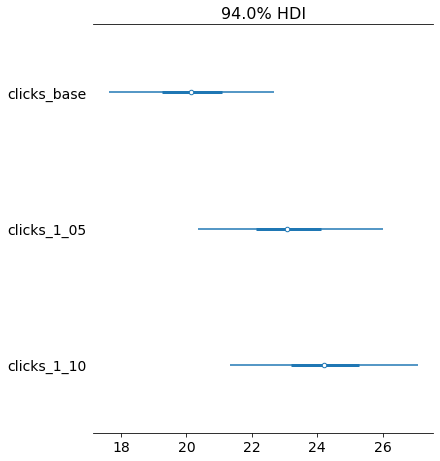

In [140]:
# let's do a forest plot

click_keys = ["clicks_base", "clicks_1_05", "clicks_1_10"]
pm.plot_forest({k:post_dict[k] for k in click_keys},  hdi_prob=0.94)

#clicks_posteriors_df[["clicks_base", "clicks_1_05", "clicks_1_10"]].to_dict()

In [141]:
# What is the probability of differences

diff_dict = {
    "1_05_diff_base" : post_dict["clicks_1_05"] -  post_dict["clicks_base"],
    "1_10_diff_base" : post_dict["clicks_1_10"] -  post_dict["clicks_base"],
    "1_10_diff_1_05" : post_dict["clicks_1_10"] -  post_dict["clicks_1_05"],
    "cost_diff" : post_dict["cost_1_10"] -  post_dict["cost_base"],   # we only have 10% increase on Impressions
}

diff_df = pd.DataFrame(diff_dict)

#prob that clicks_1_05 > clicks_base
prob_clicks_1_05_gt_base = ( diff_df["1_05_diff_base"] > 0).mean() 
avg_clicks_1_05_gt_base = diff_df.loc[diff_df["1_05_diff_base"] > 0]["1_05_diff_base"].mean()
cost_clicks_1_05_gt_base = diff_df.loc[diff_df["1_05_diff_base"] > 0]["cost_diff"].mean()

#prob that clicks_1_10 > clicks_base
prob_clicks_1_10_gt_base = ( diff_df["1_10_diff_base"] > 0).mean() 
avg_clicks_1_10_gt_base = diff_df.loc[diff_df["1_10_diff_base"] > 0]["1_10_diff_base"].mean()
cost_clicks_1_10_gt_base = diff_df.loc[diff_df["1_10_diff_base"] > 0]["cost_diff"].mean()

#prob that clicks_1_10 > clicks_1_05
prob_clicks_1_10_gt_1_05 = ( diff_df["1_10_diff_1_05"] > 0).mean() 
avg_clicks_1_10_gt_1_05 = diff_df.loc[diff_df["1_10_diff_1_05"] > 0]["1_10_diff_1_05"].mean()
cost_clicks_1_10_gt_1_05 = diff_df.loc[diff_df["1_10_diff_1_05"] > 0]["cost_diff"].mean()


print("CTR 5% is on average {:.2f} clicks greater than base with probability {:.2%} at average cost of R{:.2f} per day, given that 10% increase in Impressions produces 5% increase in CTR".format(avg_clicks_1_05_gt_base, prob_clicks_1_05_gt_base, cost_clicks_1_05_gt_base))

print("CTR 10% is on average {:.2f} clicks greater than base with probability {:.2%} at average cost of R{:.2f} per day, given that 10% increase in Impressions produces 10% increase in CTR".format(avg_clicks_1_10_gt_base, prob_clicks_1_10_gt_base, cost_clicks_1_10_gt_base))

print("CTR 10% is on average {:.2f} clicks greater than 5% increase with probability {:.2%} at average cost of R{:.2f} per day, given that 10% increase in Impressions produces 5-10% increase in CTR".format(avg_clicks_1_10_gt_1_05, prob_clicks_1_10_gt_1_05, cost_clicks_1_10_gt_1_05))


CTR 5% is on average 3.25 clicks greater than base with probability 93.15% at average cost of R9.18 per day, given that 10% increase in Impressions produces 5% increase in CTR
CTR 10% is on average 4.17 clicks greater than base with probability 97.99% at average cost of R9.17 per day, given that 10% increase in Impressions produces 10% increase in CTR
CTR 10% is on average 2.17 clicks greater than 5% increase with probability 69.98% at average cost of R9.17 per day, given that 10% increase in Impressions produces 5-10% increase in CTR


In [142]:
diff_dict["cost_diff"].mean()

9.166658305956958